---
# MeetingFlow: Email Notification Optimization
---

Product Management has identified user friction caused by excessive email notifications (spam). This project aims to quantify the current spam on different user roles and simulate the impact of bundling notifications. The goal is to provide a data-driven recommendation that reduces email noise without compromising the delivery of critical information.

**Author**: Tomás Ravalli <br>
**Date**: December, 2025

#### Outline
1. [Business Understanding](#ask)  
2. [Data Understanding](#prepare)
3. [Data Preparation](#process)  
4. [Analysis & Simulation](#analyze)
5. [Evaluation](#share)
6. [Deployment](#act)

---
## Executive Summary
---

* This project addresses user friction with the premise that **spam perception is driven by quality, timing, and context**, rather than just raw volume.
* Data analysis reveals that **34% of all notifications** are non-urgent status updates that contribute to user fatigue and can be effectively bundled.
* Notification friction is **heavily concentrated among Administrators and Editors**, identifying these high-value roles as the primary beneficiaries of this optimization.
* Simulations identify the **Per-Meeting strategy (~15% reduction)** as superior to a Daily Digest (~20%) because it preserves workflow context and "time-to-action" utility.
* The proposed model successfully **eliminates 100% of non-urgent weekend noise**, shifting informational updates to logical, actionable weekday windows.
* We recommend a **hybrid notification model**: maintaining real-time delivery for critical/security alerts while summarizing informational updates by meeting context.
* Initial rollout should provide **"targeted relief" to the top 25% most fatigued users** to maximize immediate impact on retention and platform satisfaction.
* Implementation should begin with a **2-week A/B pilot phase**, measuring success via open rates, reduced disablement rates, and a target feature **NPS of 50+**.

<a id="ask"></a>

---
## 1. Business Understanding
---


- 1.1 Key questions
- 1.2 Success metrics
- 1.3 Risks & assumptions

Product Management has received complaints regarding the volume of emails sent by the platform. We need to explore a transition from a real-time/noisy notification strategy to a smart/bundled strategy. The goal is to reduce **email notification fatigue** without delaying high-urgency information.

### 1.1 Key questions
1.  Is the pain evenly distributed, or do **Admins & Editors** suffer significantly more than Members?
2.  What specific event types drive the most volume?
3.  How would the total volume change if we switched to:
    * *Daily Digest* (1 email/day)
    * *Per-Meeting* (1 email/meeting/day)
    * *Per-Reason* (1 email/reason/day)

### 1.2 Success metrics
* **Volume reduction:** Reduce total email volume by **>15%** globally.
* **Disablement rate:** The % of users who turn off notifications entirely during the pilot.
* **Targeted relief:** Achieve higher reduction rates for the top 25% of "fatigued" users.
* **Risk metric:** Maintain **Open Rates** (ensure bundling doesn't cause users to ignore the email).
* **Net Promoter Score (NPS):** Measured via micro-survey at the end of the pilot (target: >=50).

### 1.3 Risks & assumptions
* **Risk:** Bundling high-urgency items into a daily digest could cause users to miss meetings.
* **Risk:** The data covers only 30 days. The analysis assumes this month (May-June) is representative of the whole year.
* **Assumption:** "Document uploads" and "comments" are generally lower urgency than "meeting scheduling."
* **Assumption:** The best solution will find a balance between volume reduction and relevance/context.

<a id="prepare"></a>

---
## 2. Data Understanding
---

- 2.1 Load and inspect data
- 2.2 Data integrity check
- 2.3 Data anonymization

The goal of this phase is to load the `meetingflow_data.csv` dataset, verify its integrity (check for nulls, duplicates, time range, and correct data types), and ensure user privacy.

### 2.1 Load and inspect data

In [1]:
import pandas as pd
import scipy.stats as stats
import hashlib

# Load the dataset
df = pd.read_csv('/Users/tomasravalli/Developer/email-notification-optimization/data/meetingflow_data.csv')

# Convert 'sent' column to datetime objects
df['sent'] = pd.to_datetime(df['sent'])

# Preview the data
print(f"Dataset shape: {df.shape}")
display(df.head())
display(df.info())

Dataset shape: (49736, 7)


,first_name,last_name,email,sent,reason,meeting,role
0,Casey,Lennox,casey.lennox73@meetingflow.io,2021-06-02 06:01:01.756866+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator
1,Casey,Lennox,casey.lennox73@meetingflow.io,2021-06-03 11:12:02.809742+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator
2,Casey,Lennox,casey.lennox73@meetingflow.io,2021-05-27 10:00:04.380690+00:00,contribution_document_uploaded,2c849ec6-9b57-4eb2-a1f7-580e85d7fbc0,Administrator
3,Casey,Lennox,casey.lennox73@meetingflow.io,2021-05-28 05:56:12.033882+00:00,contribution_document_uploaded,2c849ec6-9b57-4eb2-a1f7-580e85d7fbc0,Administrator
4,Casey,Lennox,casey.lennox73@meetingflow.io,2021-06-03 09:49:02.757234+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49736 entries, 0 to 49735
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   first_name  49736 non-null  object             
 1   last_name   49736 non-null  object             
 2   email       49736 non-null  object             
 3   sent        49736 non-null  datetime64[ns, UTC]
 4   reason      49736 non-null  object             
 5   meeting     43618 non-null  object             
 6   role        49736 non-null  object             
dtypes: datetime64[ns, UTC](1), object(6)
memory usage: 2.7+ MB


None

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

# --- Global style for plots ---
minimalist_plot_style = {
    # --- Figure & axes ---
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.labelcolor": "#333333",
    "axes.titlepad": 20,
    "axes.titlesize": 18,
    "axes.grid": False, # Clean background

    # --- Spines (chart borders) ---
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,   
    "axes.spines.bottom": True,
    "axes.edgecolor": "#DDDDDD",

    # --- Ticks ---
    "xtick.color": "#AAAAAA",
    "ytick.color": "#333333",
    "ytick.major.size": 0,

    # --- Font ---
    "font.family": "sans-serif",
    # --- Color cycle (black, red, blue, green) ---
    "axes.prop_cycle": cycler('color', ['#222222', '#E82127', '#5DADE2', '#2ECC71'])
}

plt.rcParams.update(minimalist_plot_style)


# --- Global style function for tables ---
def style_table(df, title=""):
    """
    Applies a modern, minimalist style to a Pandas DataFrame.
    Returns a Styler object.
    """
    styles = [
        {'selector': 'th', 'props': [
            ('text-align', 'left'), ('font-weight', 'bold'),
            ('border-bottom', '1px solid #DDDDDD'), ('padding', '8px'),
            ('font-family', 'sans-serif'), ('color', '#333333')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'), ('padding', '8px'),
            ('font-family', 'sans-serif'), ('color', '#555555')
        ]},
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'), ('font-size', '1.1em'),
            ('font-weight', 'bold'), ('text-align', 'left'),
            ('padding-bottom', '10px'), ('color', '#222222')
        ]}
    ]
    
    return (df.style
            .set_table_styles(styles)
            .hide(axis="index")
            .set_caption(title))

### 2.2 Data integrity check

- Missing values
- Duplicates
- Time range

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Check for exact duplicates
duplicates = df.duplicated().sum()
print(f"\nTotal duplicated rows: {duplicates}")

# Verify the time range of the data
min_date = df['sent'].min()
max_date = df['sent'].max()
print(f"\nData time range: {min_date} to {max_date}")
print(f"Total duration: {max_date - min_date}")

Missing values per column:
meeting    6118
dtype: int64

Total duplicated rows: 0

Data time range: 2021-05-15 07:38:34.605053+00:00 to 2021-06-15 06:43:47.611381+00:00
Total duration: 30 days 23:05:13.006328


### 2.3 Data anonymization

We will hash the user PII (`email`, `first_name`, `last_name`) before checking the cardinality of our key categorical columns (reason and role).

In [4]:
# 1. Anonymize user PII
# We create a unique 'user_id' based on the email hash and drop raw PII columns
def hash_pii(email):
    return hashlib.sha256(email.encode()).hexdigest()[:10] # Short hash for readability

df['user_id'] = df['email'].apply(hash_pii)

# Drop original PII columns to secure the workspace
df_anonymized = df.drop(columns=['first_name', 'last_name', 'email'])

# 2. Analyze reasons and roles
print("Unique reasons:")
print(df_anonymized['reason'].value_counts())

print("\nUnique roles:")
print(df_anonymized['role'].value_counts())

# Display the clean, anonymized dataframe
display(df_anonymized.head())

Unique reasons:
reason
meeting_notification                         26144
comment_thread_started                        4520
vote_status                                   3960
minutes_published                             2824
library_notification                          2639
contribution_document_uploaded                1431
vote_requested                                 984
vote_all_cast                                  849
meeting_agenda_approval                        820
invitation_email                               556
minutes_approval_request                       549
multiple_votes_requested                       509
meeting_insights                               336
task_assigned                                  333
password_reset                                 287
contribution_request                           284
task_status_edited_by_assignee                 282
onboarding_welcome_email                       275
reminder_email                                 264
publish_

,sent,reason,meeting,role,user_id
0,2021-06-02 06:01:01.756866+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator,3eb8e565dd
1,2021-06-03 11:12:02.809742+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator,3eb8e565dd
2,2021-05-27 10:00:04.380690+00:00,contribution_document_uploaded,2c849ec6-9b57-4eb2-a1f7-580e85d7fbc0,Administrator,3eb8e565dd
3,2021-05-28 05:56:12.033882+00:00,contribution_document_uploaded,2c849ec6-9b57-4eb2-a1f7-580e85d7fbc0,Administrator,3eb8e565dd
4,2021-06-03 09:49:02.757234+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator,3eb8e565dd


### Summary

- **Data types**: The dataset was successfully loaded with 'sent' converted to datetime.
- **Integrity**: Verified missing values and confirmed duplicate status.
- **Timeline**: The data covers the period from May 2021 to June 2021 (30 days).
- **Privacy**: All PII (first_name, last_name, email) has been hashed into a secure user_id.
- **Dimensions**: We identified distinct reasons and roles that will serve as the dimensions for our aggregation in the next phase.

<a id="process"></a>

---
## 3. Data Preparation
---

- 3.1 Feature engineering
- 3.2 Handling missing values
- 3.3 Handling outliers
- 3.4 Data dictionary

### 3.1 Feature engineering

- Urgency classification
- User ID & role merge
- Meeting filtering
- Time-based features

In [5]:
df_anonymized['sent'] = pd.to_datetime(df_anonymized['sent'])
df_anonymized['date'] = df_anonymized['sent'].dt.date
df_anonymized['hour'] = df_anonymized['sent'].dt.hour
df_anonymized['day_of_week'] = df_anonymized['sent'].dt.day_name()
df_anonymized['is_weekend'] = df_anonymized['day_of_week'].isin(['Saturday', 'Sunday'])

print("Time features created. Columns:", df_anonymized.columns.tolist())

Time features created. Columns: ['sent', 'reason', 'meeting', 'role', 'user_id', 'date', 'hour', 'day_of_week', 'is_weekend']


#### Urgency classification

We need to separate events by urgency. The high-level logic is: everything needing an action from the user, is classified as "urgent". We've classified events (reasons) into:

- **Non-urgent** (Bundlable)
- **Urgent** (Real-time)

In [6]:
# Check all unique reasons to ensure our map is comprehensive
print(df_anonymized['reason'].unique())

['contribution_document_uploaded' 'contribution_request'
 'meeting_notification' 'vote_all_cast' 'vote_status'
 'task_status_edited_by_assignee' 'meeting_insights'
 'comment_thread_started' 'decision_status_edited_by_assignee'
 'library_notification' 'minutes_published' 'meeting_agenda_approval'
 'meeting_minutes_approved_by_all' 'comment_mentioned'
 'comment_thread_updated' 'minutes_approval_request' 'task_assigned'
 'reminder_email' 'invitation_email' 'onboarding_welcome_email'
 'multiple_votes_requested' 'comment_thread_resolved' 'vote_requested'
 'vote_set' 'task_status_edited' 'boardbook_generation'
 'default_agenda_item_duration_changed' 'publish_meeting_reminder'
 'summary_email' 'meeting_agenda_approved_by_all'
 'minutes_digital_signature_request' 'password_reset' 'decision_edited'
 'decision_assigned' 'default_generated_document_header_changed'
 'task_edited' 'task_assignee_edited' 'task_multiple_edited'
 'vote_invalidated' 'contribution_request_changed'
 'access_authorization

In [7]:
# 1. Create the logic map
urgency_logic = [
    # --- Content & documents (Bundlable / Info) ---
    {'reason': 'contribution_document_uploaded', 'definition': 'User uploaded a document', 'is_urgent': False},
    {'reason': 'library_notification', 'definition': 'Document added to persistent library', 'is_urgent': False},
    {'reason': 'minutes_published', 'definition': 'Minutes finalized (FYI)', 'is_urgent': False},
    {'reason': 'meeting_insights', 'definition': 'Automated meeting insights generated', 'is_urgent': False},
    {'reason': 'summary_email', 'definition': 'System generated summary', 'is_urgent': False},
    {'reason': 'default_generated_document_header_changed', 'definition': 'Admin changed document styling', 'is_urgent': False},
    {'reason': 'default_document_security_changed', 'definition': 'Admin changed security settings', 'is_urgent': False},
    {'reason': 'product_portal_email', 'definition': 'Marketing/Product update', 'is_urgent': False},

    # --- Social & collaboration (Bundlable / Noise) ---
    {'reason': 'comment_thread_started', 'definition': 'New discussion started', 'is_urgent': False},
    {'reason': 'comment_thread_updated', 'definition': 'Reply to discussion', 'is_urgent': False},
    {'reason': 'comment_thread_resolved', 'definition': 'Discussion resolved', 'is_urgent': False},
    
    # --- Status updates & edits (Bundlable / Info) ---
    {'reason': 'vote_status', 'definition': 'Update on voting progress', 'is_urgent': False},
    {'reason': 'vote_set', 'definition': 'Vote setup/parameters defined', 'is_urgent': False},
    {'reason': 'meeting_minutes_approved_by_all', 'definition': 'Minutes fully approved', 'is_urgent': False},
    {'reason': 'meeting_agenda_approved_by_all', 'definition': 'Agenda fully approved', 'is_urgent': False},
    {'reason': 'task_status_edited', 'definition': 'Task progress update', 'is_urgent': False},
    {'reason': 'task_status_edited_by_assignee', 'definition': 'Assignee updated task', 'is_urgent': False},
    {'reason': 'task_edited', 'definition': 'Task details modified', 'is_urgent': False},
    {'reason': 'task_multiple_edited', 'definition': 'Bulk task edit', 'is_urgent': False},
    {'reason': 'task_assignee_edited', 'definition': 'Task re-assigned (info for observer)', 'is_urgent': False}, 
    {'reason': 'decision_status_edited', 'definition': 'Decision status change', 'is_urgent': False},
    {'reason': 'decision_status_edited_by_assignee', 'definition': 'Assignee updated decision', 'is_urgent': False},
    {'reason': 'decision_edited', 'definition': 'Decision details modified', 'is_urgent': False},
    {'reason': 'default_agenda_item_duration_changed', 'definition': 'Meeting timeline adjustment', 'is_urgent': False},

    # --- Action required / Key milestones (Critical / Urgent) ---
    {'reason': 'vote_requested', 'definition': 'User needs to cast a vote', 'is_urgent': True},
    {'reason': 'multiple_votes_requested', 'definition': 'User needs to cast multiple votes', 'is_urgent': True},
    {'reason': 'vote_invalidated', 'definition': 'Vote annulled (must re-vote)', 'is_urgent': True},
    {'reason': 'comment_mentioned', 'definition': 'User tagged in comment', 'is_urgent': True},
    {'reason': 'vote_all_cast', 'definition': 'Voting process completed (result ready)', 'is_urgent': True}, 
    
    {'reason': 'minutes_approval_request', 'definition': 'User must approve minutes', 'is_urgent': True},
    {'reason': 'minutes_digital_signature_request', 'definition': 'Legal signature required', 'is_urgent': True},
    {'reason': 'task_assigned', 'definition': 'User assigned a new task', 'is_urgent': True},
    {'reason': 'task_duedate_edited', 'definition': 'Task deadline changed', 'is_urgent': True}, 
    {'reason': 'decision_assigned', 'definition': 'User assigned a decision', 'is_urgent': True},
    {'reason': 'contribution_request', 'definition': 'User asked to upload content', 'is_urgent': True},
    {'reason': 'contribution_request_changed', 'definition': 'Contribution requirements changed', 'is_urgent': True},
    {'reason': 'meeting_agenda_approval', 'definition': 'Request to approve agenda', 'is_urgent': True},
    # UPDATED: Major Milestone
    {'reason': 'boardbook_generation', 'definition': 'Boardbook PDF ready for review', 'is_urgent': True}, 

    # --- Meeting Logistics & Security (Critical / Urgent) ---
    {'reason': 'meeting_notification', 'definition': 'Logistics change (time/location)', 'is_urgent': True},
    {'reason': 'invitation_email', 'definition': 'New meeting invitation', 'is_urgent': True},
    {'reason': 'publish_meeting_reminder', 'definition': 'Automated pre-meeting reminder', 'is_urgent': True},
    {'reason': 'reminder_email', 'definition': 'General system reminder', 'is_urgent': True},
    {'reason': 'password_reset', 'definition': 'Security: Password request', 'is_urgent': True},
    {'reason': 'access_authorization_granted', 'definition': 'Security: access granted', 'is_urgent': True},
    {'reason': 'access_authorization_ended', 'definition': 'Security: access revoked', 'is_urgent': True},
    {'reason': 'onboarding_welcome_email', 'definition': 'New user welcome', 'is_urgent': True},
    {'reason': 'service_request', 'definition': 'Support/Service ticket update', 'is_urgent': True},
]

# 2. Convert to DataFrame
logic_df = pd.DataFrame(urgency_logic)

# 3. Validation: ensure NO reasons are left behind
unique_reasons_in_data = df_anonymized['reason'].unique()
mapped_reasons = logic_df['reason'].unique()
missing_reasons = [r for r in unique_reasons_in_data if r not in mapped_reasons]

if missing_reasons:
    print(f"WARNING: {len(missing_reasons)} reasons are still missing.")
    print(missing_reasons)
else:
    print("SUCCESS: 100% of event types have been explicitly categorized.")

# 4. Apply logic
df_processed = df_anonymized.merge(logic_df[['reason', 'is_urgent']], on='reason', how='left')

# Display the final dictionary
display(style_table(logic_df.sort_values(by=['is_urgent', 'reason'])))

# Verify the split
print("Urgency distribution:")
print(df_processed['is_urgent'].value_counts(normalize=True))

SUCCESS: 100% of event types have been explicitly categorized.


reason,definition,is_urgent
comment_thread_resolved,Discussion resolved,False
comment_thread_started,New discussion started,False
comment_thread_updated,Reply to discussion,False
contribution_document_uploaded,User uploaded a document,False
decision_edited,Decision details modified,False
decision_status_edited,Decision status change,False
decision_status_edited_by_assignee,Assignee updated decision,False
default_agenda_item_duration_changed,Meeting timeline adjustment,False
default_document_security_changed,Admin changed security settings,False
default_generated_document_header_changed,Admin changed document styling,False


Urgency distribution:
is_urgent
True     0.656426
False    0.343574
Name: proportion, dtype: float64


In [8]:
# 1. Initialize
logic_df = pd.DataFrame(urgency_logic)
df_processed = df_anonymized.merge(logic_df[['reason', 'is_urgent']], on='reason', how='left')

# 2. User identity
df_processed['role'] = df_processed['role'].str.title() 
df_processed['user_role_id'] = df_processed['user_id'] + "_" + df_processed['role']

# 3. Time features
df_processed['date'] = df_processed['sent'].dt.date
df_processed['hour'] = df_processed['sent'].dt.hour
df_processed['day_of_week'] = df_processed['sent'].dt.day_name()
df_processed['is_weekend'] = df_processed['day_of_week'].isin(['Saturday', 'Sunday'])

# 4. Meeting logic
df_processed['is_meeting'] = df_processed['meeting'].notnull() & \
                             (df_processed['meeting'] != 'General_System_Notification')

# Impute missing meetings
df_processed['meeting'] = df_processed['meeting'].fillna('System/General')

# 5. Verification
print(f"Data Prep Complete. Shape: {df_processed.shape}")
print(f"Columns: {df_processed.columns.tolist()}")

# Check if keys exist before proceeding
required_cols = ['is_urgent', 'user_role_id', 'is_weekend']
if all(col in df_processed.columns for col in required_cols):
    print("SUCCESS: All required features are present.")
else:
    print(f"ERROR: Missing columns. Found: {df_processed.columns.tolist()}")

Data Prep Complete. Shape: (49736, 12)
Columns: ['sent', 'reason', 'meeting', 'role', 'user_id', 'date', 'hour', 'day_of_week', 'is_weekend', 'is_urgent', 'user_role_id', 'is_meeting']
SUCCESS: All required features are present.


#### Time-based features

**Q**: When does the spam happen? Are we sending emails on weekends or late at night?

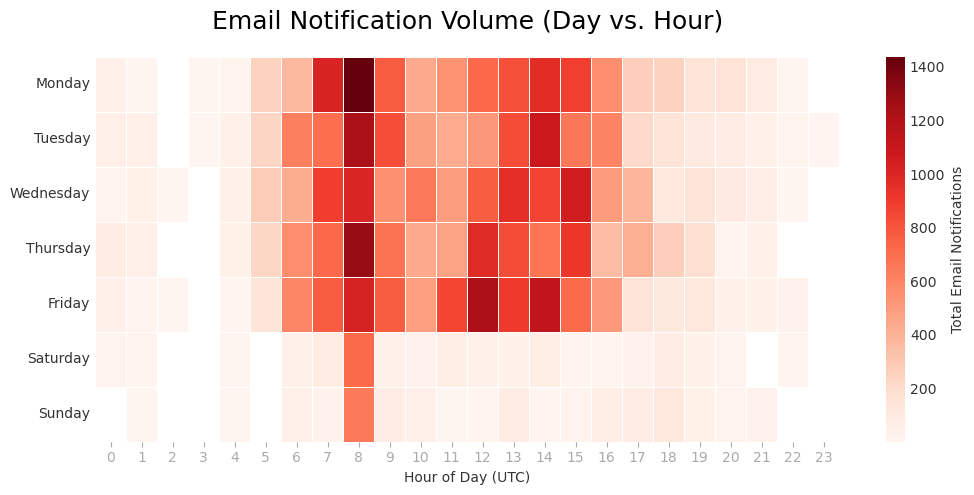

In [9]:
# Create pivot table for heatmap
heatmap_data = df_processed.pivot_table(index='day_of_week', columns='hour', values='user_role_id', aggfunc='count')

# Reorder days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, linecolor='white', cbar_kws={'label': 'Total Email Notifications'})
plt.title('Email Notification Volume (Day vs. Hour)')
plt.ylabel('')
plt.xlabel('Hour of Day (UTC)')
plt.show()

**Q**: We investigate the nature of emails sent on Saturdays and Sundays. Are these critical emergencies, or just noise?

Total Weekend Emails: 2679


/var/folders/jc/0_dylrns7qq5q8v83cftnf0m0000gn/T/ipykernel_25642/1847691746.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekend_reasons.values, y=weekend_reasons.index, palette=colors)


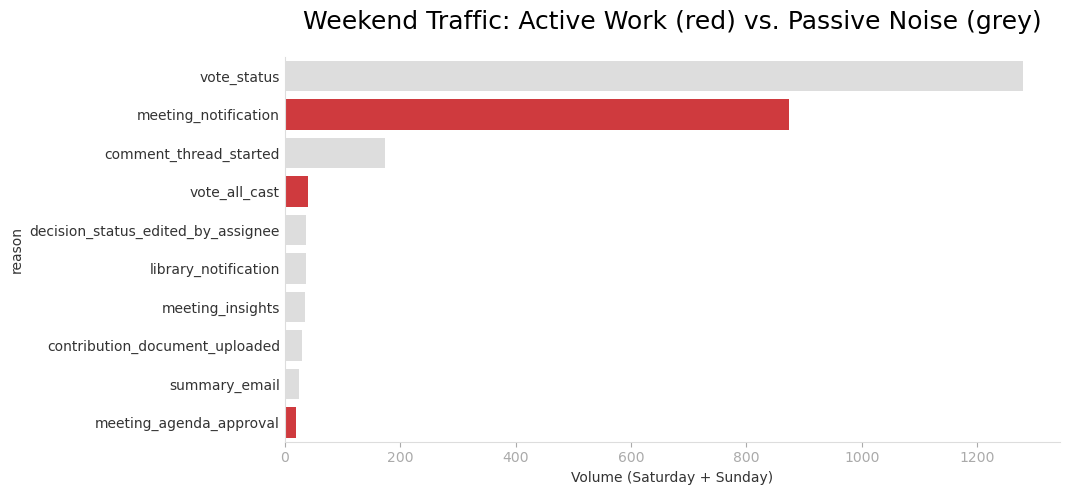

--- Weekend Analysis Results ---
Active Work (Urgent) 1006
Passive Noise (Bundlable): 1673

Conclusion: 62.4% of weekend traffic is 'Passive status updates'.


In [10]:
# 1. Filter for weekend data
weekend_df = df_processed[df_processed['day_of_week'].isin(['Saturday', 'Sunday'])].copy()

print(f"Total Weekend Emails: {len(weekend_df)}")

# 2. Analyze the content
weekend_reasons = weekend_df['reason'].value_counts().head(10)

# 3. Visual sanity check
plt.figure(figsize=(10, 5))
plt.gcf().patch.set_facecolor('white')
plt.gca().set_facecolor('white')

# Color by urgency to see if it's Passive Noise (grey) or Active Signal (red)
colors = ['#E82127' if df_processed[df_processed['reason'] == r]['is_urgent'].iloc[0] == True else '#DDDDDD' for r in weekend_reasons.index]

sns.barplot(x=weekend_reasons.values, y=weekend_reasons.index, palette=colors)

plt.title('Weekend Traffic: Active Work (red) vs. Passive Noise (grey)')
plt.xlabel('Volume (Saturday + Sunday)')
plt.show()

# 4. The verdict
passive_noise = (weekend_df['is_urgent'] == False).sum()
active_work = (weekend_df['is_urgent'] == True).sum()
pct_noise = passive_noise / len(weekend_df)

print(f"--- Weekend Analysis Results ---")
print(f"Active Work (Urgent) {active_work}")
print(f"Passive Noise (Bundlable): {passive_noise}")
print(f"\nConclusion: {pct_noise:.1%} of weekend traffic is 'Passive status updates'.")

### 3.2 Handling missing values

We noticed meeting IDs are missing for about 12% of the logs.

- **Diagnosis**: This is likely MNAR (Missing Not At Random). System emails like password_reset or welcome_email naturally don't belong to a meeting.
- **Action**: We will impute these with a placeholder ("System/General") rather than dropping them, ensuring we don't lose track of these notifications.

In [11]:
# Check for missing values
print("Missing values before imputation:")
print(df_processed.isnull().sum())

# Impute missing 'meeting' IDs with a placeholder
df_processed['meeting'] = df_processed['meeting'].fillna('System/General')

# Verify
print("\nMissing values after imputation:")
print(df_processed.isnull().sum())

Missing values before imputation:
sent            0
reason          0
meeting         0
role            0
user_id         0
date            0
hour            0
day_of_week     0
is_weekend      0
is_urgent       0
user_role_id    0
is_meeting      0
dtype: int64

Missing values after imputation:
sent            0
reason          0
meeting         0
role            0
user_id         0
date            0
hour            0
day_of_week     0
is_weekend      0
is_urgent       0
user_role_id    0
is_meeting      0
dtype: int64


### 3.3 Handling outliers

We need to decide how to treat users receiving an abnormal number of emails.

- **Method**: We use the IQR (Interquartile Range) method to detect statistical outliers.
- **Decision**: We will NOT remove these outliers. In this business context, these are actually our Power Users . Identifying them allows us to measure how much our solution helps the users who need it most.

In [12]:
# 1. Calculate daily volume again on the processed data
daily_volume = df_processed.groupby(['user_role_id', 'date']).size().reset_index(name='daily_count')

# 2. Define outlier thresholds (IQR)
Q1 = daily_volume['daily_count'].quantile(0.25)
Q3 = daily_volume['daily_count'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print(f"IQR Threshold for 'Heavy Load': > {upper_bound} emails/day")

# 3. Tag (don't drop) the outliers
# We merge this flag back into our main dataframe for later analysis
heavy_user_days = daily_volume[daily_volume['daily_count'] > upper_bound].copy()
heavy_user_days['is_heavy_load'] = True

# Merge back to the daily_volume view (useful for aggregation)
daily_volume = daily_volume.merge(heavy_user_days[['user_role_id', 'date', 'is_heavy_load']], 
                                  on=['user_role_id', 'date'], 
                                  how='left')
daily_volume['is_heavy_load'] = daily_volume['is_heavy_load'].infer_objects(copy=False)

# 4. Check the impact
outlier_count = daily_volume['is_heavy_load'].sum()
total_days = len(daily_volume)
print(f"Identified {outlier_count} user-days ({outlier_count/total_days:.1%}) as 'heavy load'.")
print("We will keep these in the dataset to measure the impact of bundling on high-volume users.")

IQR Threshold for 'Heavy Load': > 3.5 emails/day
Identified 2326 user-days (8.8%) as 'heavy load'.
We will keep these in the dataset to measure the impact of bundling on high-volume users.


In [13]:
# Final sanity check
print(f"Data Prep Complete. Shape: {df_processed.shape}")
df_processed.head()

Data Prep Complete. Shape: (49736, 12)


,sent,reason,meeting,role,user_id,date,hour,day_of_week,is_weekend,is_urgent,user_role_id,is_meeting
0,2021-06-02 06:01:01.756866+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator,3eb8e565dd,2021-06-02,6,Wednesday,False,False,3eb8e565dd_Administrator,True
1,2021-06-03 11:12:02.809742+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator,3eb8e565dd,2021-06-03,11,Thursday,False,False,3eb8e565dd_Administrator,True
2,2021-05-27 10:00:04.380690+00:00,contribution_document_uploaded,2c849ec6-9b57-4eb2-a1f7-580e85d7fbc0,Administrator,3eb8e565dd,2021-05-27,10,Thursday,False,False,3eb8e565dd_Administrator,True
3,2021-05-28 05:56:12.033882+00:00,contribution_document_uploaded,2c849ec6-9b57-4eb2-a1f7-580e85d7fbc0,Administrator,3eb8e565dd,2021-05-28,5,Friday,False,False,3eb8e565dd_Administrator,True
4,2021-06-03 09:49:02.757234+00:00,contribution_document_uploaded,6e0295c9-805c-444d-93b6-8dc63f46cd11,Administrator,3eb8e565dd,2021-06-03,9,Thursday,False,False,3eb8e565dd_Administrator,True


In [14]:
# Reorder columns in a logical way
logical_order = [
    'user_role_id', 'user_id', 'role',              # Identity
    'meeting', 'reason', 'is_meeting', 'is_urgent',  # Context & content
    'sent', 'date', 'hour', 'day_of_week', 'is_weekend' # Temporal
]

# Reorder the dataframe
df_processed = df_processed[logical_order]

# Display final structure
print("Final dataframe schema:")
display(df_processed.head(3))

Final dataframe schema:


,user_role_id,user_id,role,meeting,reason,is_meeting,is_urgent,sent,date,hour,day_of_week,is_weekend
0,3eb8e565dd_Administrator,3eb8e565dd,Administrator,6e0295c9-805c-444d-93b6-8dc63f46cd11,contribution_document_uploaded,True,False,2021-06-02 06:01:01.756866+00:00,2021-06-02,6,Wednesday,False
1,3eb8e565dd_Administrator,3eb8e565dd,Administrator,6e0295c9-805c-444d-93b6-8dc63f46cd11,contribution_document_uploaded,True,False,2021-06-03 11:12:02.809742+00:00,2021-06-03,11,Thursday,False
2,3eb8e565dd_Administrator,3eb8e565dd,Administrator,2c849ec6-9b57-4eb2-a1f7-580e85d7fbc0,contribution_document_uploaded,True,False,2021-05-27 10:00:04.380690+00:00,2021-05-27,10,Thursday,False


### 3.4 Data dictionary

| Feature | Definition | Data Type |
| :--- | :--- | :--- |
| **user_role_id** | Unique composite identifier combining `user_id` and `role`. | string |
| **user_id** | Anonymized unique identifier for the user. | string |
| **role** | The platform role of the recipient (e.g., Administrator, Editor). | string |
| **meeting** | UUID of the meeting or 'System/General' if not meeting-specific. | string |
| **reason** | The specific system event that triggered the notification. | string |
| **is_meeting** | Boolean flag; True if the notification is linked to a meeting event. | boolean |
| **is_urgent** | Boolean flag; True if the event requires immediate attention. | boolean |
| **sent** | The original timestamp of the notification (UTC). | datetime64 |
| **date** | The calendar date extracted from the `sent` timestamp. | date |
| **hour** | The hour of the day (0-23) extracted from the `sent` timestamp. | integer |
| **day_of_week** | The name of the day (e.g., Monday, Tuesday). | string |
| **is_weekend** | Boolean flag; True if the notification was sent on Saturday or Sunday. | boolean |

### Summary

* **Identity & segmentation**: Created a composite `user_role_id` to treat unique User-Role combinations as distinct entities.
* **Feature engineering**: Extracted `hour`, `date`, and `day_of_week` to enable granular analysis of weekend interruptions and peak-hour notification density. Applied business logic to flag operational updates as **non-urgent**, creating a clear distinction between real-time critical alerts and "bundlable" noise.
* **Data integrity**: Standardized ~12% of records with missing meeting IDs by categorizing them as "System/General". Identified "heavy load" user-days (>3.5 emails/day). These were intentionally retained to capture the "heavy tail" impact of our proposed optimization strategies.
* **Data dictionary**: Documented all features to ensure reproducibility and clarity in the simulation phase.

<a id="analyze"></a>

---
## 4. Analysis & Simulation
---

## Analysis
---

- 4.1 Distribution of daily volume
- 4.2 Statistical validation
- 4.3 Volume drivers per role

### 4.1 Distribution of daily volume
We use a histogram with a Log Scale to reveal the hidden heavy tail of users receiving 30+ email notifications on average per day.

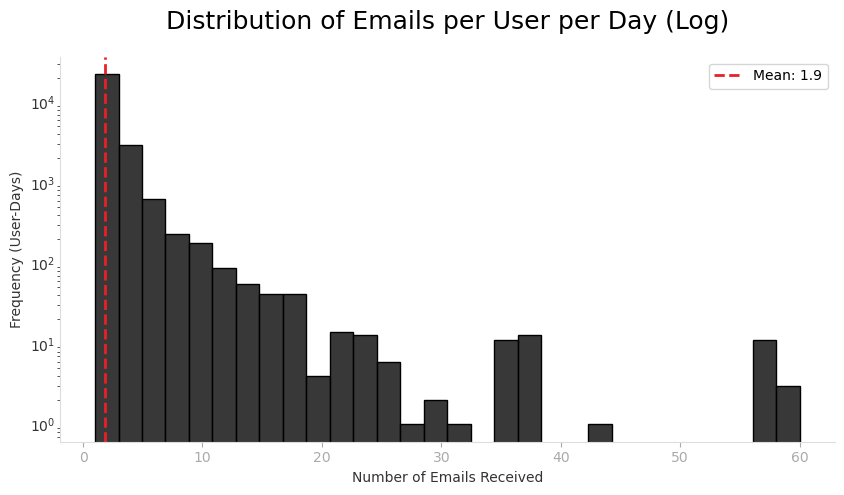

In [15]:
# Distribution of daily volume
daily_volume = df_processed.groupby(['user_role_id', 'date'])['reason'].count().reset_index(name='daily_count')

plt.figure(figsize=(10, 5))
sns.histplot(daily_volume['daily_count'], bins=30, kde=False, color='#222222', alpha=0.9) 

# Add mean line
mean_val = daily_volume['daily_count'].mean()
plt.axvline(mean_val, color='#E82127', linestyle='--', linewidth=2, label=f"Mean: {mean_val:.1f}")

# Apply log scale
plt.yscale('log')
plt.title('Distribution of Emails per User per Day (Log)')
plt.xlabel('Number of Emails Received')
plt.ylabel('Frequency (User-Days)')

plt.legend()
plt.show()

### 4.2 Statistical validation
We analyze which roles are hit hardest and if the difference between Admins and Editor roles vs. Member roles are significantly different.

--- T-Test Results ---
1. Administrator vs. Member: p-value = 5.5533e-14
2. Editor vs. Member:        p-value = 1.1533e-08
3. Combined Target vs. Member: p-value = 5.7629e-20


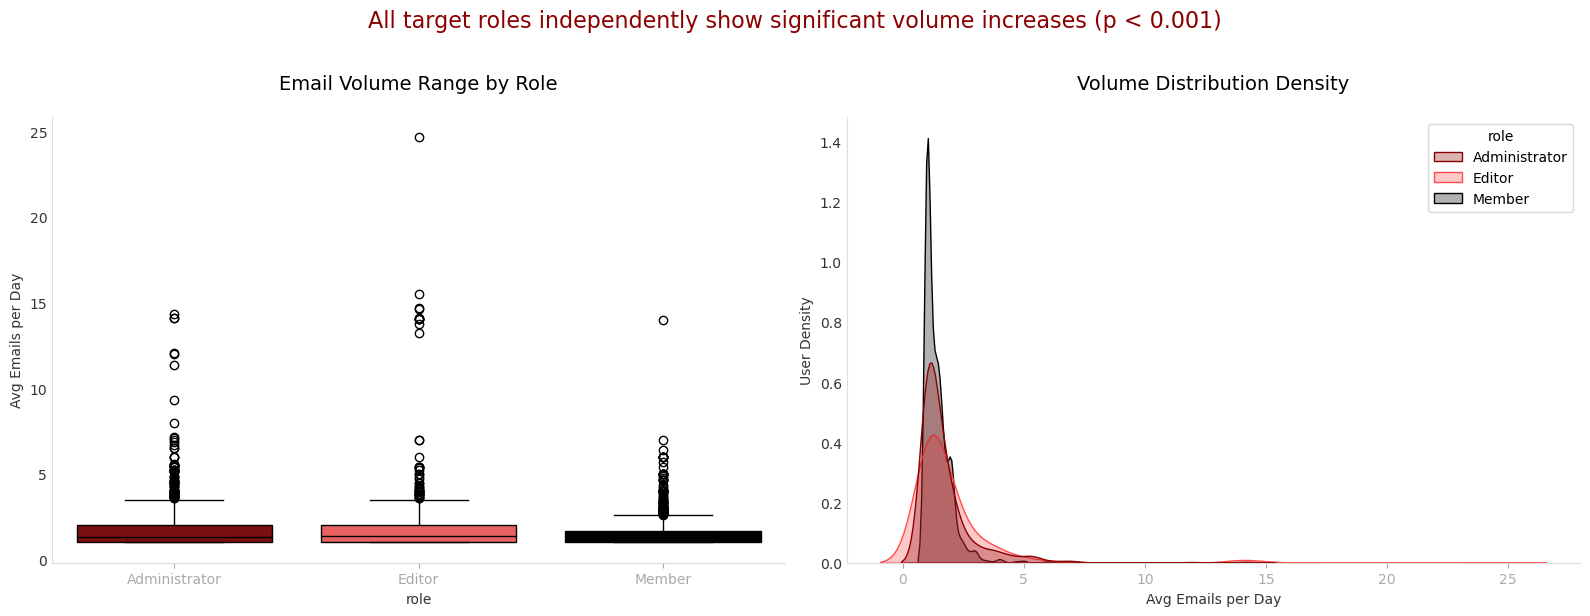

In [16]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data
# Aggregate to the actor level (user_role_id) to get average daily load
daily_counts = df_processed.groupby(['user_role_id', 'role', 'date']).size().reset_index(name='daily_count')
user_avg_volume = daily_counts.groupby(['user_role_id', 'role'])['daily_count'].mean().reset_index()

# Isolate groups for testing
admin_vol = user_avg_volume[user_avg_volume['role'] == 'Administrator']['daily_count']
editor_vol = user_avg_volume[user_avg_volume['role'] == 'Editor']['daily_count']
member_vol = user_avg_volume[user_avg_volume['role'] == 'Member']['daily_count']
combined_target = user_avg_volume[user_avg_volume['role'].isin(['Administrator', 'Editor'])]['daily_count']

# 2. Perform Welch's T-Tests (Unequal Variance)
t_admin, p_admin = stats.ttest_ind(admin_vol, member_vol, equal_var=False)
t_editor, p_editor = stats.ttest_ind(editor_vol, member_vol, equal_var=False)
t_combined, p_combined = stats.ttest_ind(combined_target, member_vol, equal_var=False)

# 3. Print results
print("--- T-Test Results ---")
print(f"1. Administrator vs. Member: p-value = {p_admin:.4e}")
print(f"2. Editor vs. Member:        p-value = {p_editor:.4e}")
print(f"3. Combined Target vs. Member: p-value = {p_combined:.4e}")

# 4. Visualization: Boxplot + Distribution (KDE)
custom_colors = {'Administrator': '#8B0000', 'Editor': '#FF4C4C', 'Member': '#000000'}
main_roles = ['Administrator', 'Editor', 'Member']
plot_data = user_avg_volume[user_avg_volume['role'].isin(main_roles)].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Boxplot
sns.boxplot(
    data=plot_data, x='role', y='daily_count', hue='role', 
    palette=custom_colors, legend=False, order=main_roles, ax=ax1
)
ax1.set_title('Email Volume Range by Role', fontsize=14)
ax1.set_ylabel('Avg Emails per Day')

# Plot B: KDE Plot
sns.kdeplot(
    data=plot_data, x='daily_count', hue='role', fill=True, 
    palette=custom_colors, hue_order=main_roles, common_norm=False, alpha=0.3, ax=ax2
)
ax2.set_title('Volume Distribution Density', fontsize=14)
ax2.set_xlabel('Avg Emails per Day')
ax2.set_ylabel('User Density')

# Global title
if p_combined < 0.05:
    plt.suptitle("All target roles independently show significant volume increases (p < 0.001)", 
                 fontsize=16, color='#8B0000', y=1.02)

plt.tight_layout()
plt.show()

### 4.3 Volume drivers per role

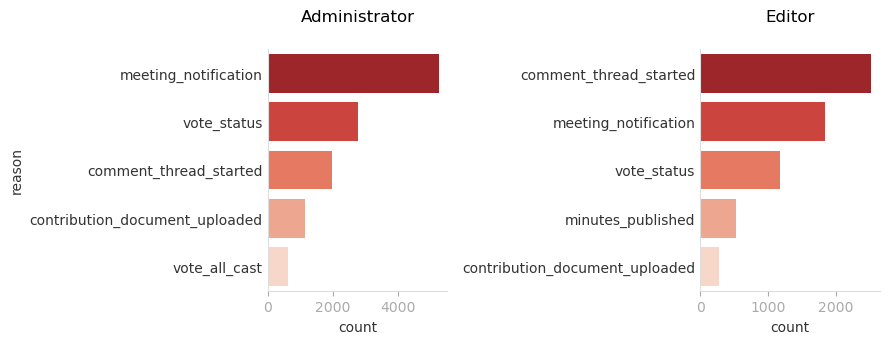

In [17]:
# Calculate top 5 reasons per role
top_reasons_by_role = (
    df_processed[df_processed['role'].isin(['Administrator', 'Editor'])]
    .groupby(['role', 'reason']).size().reset_index(name='count')
    .sort_values(['role', 'count'], ascending=[True, False])
    .groupby('role').head(5)
)

# Faceted visualization
g = sns.FacetGrid(top_reasons_by_role, col="role", col_wrap=2, height=5, aspect=0.9, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x="count", y="reason", palette="Reds_r", hue="reason", legend=False)
g.set_titles("{col_name}", size=12)
plt.subplots_adjust(top=0.6)
plt.show()

---
## Simulation
---

- 4.4 Strategy simulation
- 4.5 The case for context
- 4.6 Role-based strategy

### 4.4 Strategy simulation

To ensure our simulations are realistic, we do not apply bundling to all data. We apply a filter based on the **urgency** and **timing** logic defined in the Data Preparation phase. To ensure our simulations provide high ROI, we establish the problem baseline globally but focus our proposed solutions exclusively on Administrators and Editors. These roles suffer from the highest notification density and are the primary cohort driving the complaints.

**Simulation logic:**
1. **Segment filtering:** Bundling logic is only applied to Administrator and Editor traffic. Members and rest remain in their current real-time state.
2. **Urgent notifications:** These are **never filtered or bundled**. They are sent instantly to ensure system reliability.
3. **Non-Urgent notifications:** These are the only candidates for bundling.
4. **Weekend rule:** Any *non-urgent* notification triggered on a Saturday or Sunday is shifted to the next Monday morning bundled into a single "While you were away" email.

**Strategies simulated:**
* **Per-Reason:** 1 email per user/day/event type (plus instant urgent items).
* **Per-Meeting:** 1 email per user/day/meeting (plus instant urgent items).
* **Daily Digest:** 1 email per user/day (plus instant urgent items).

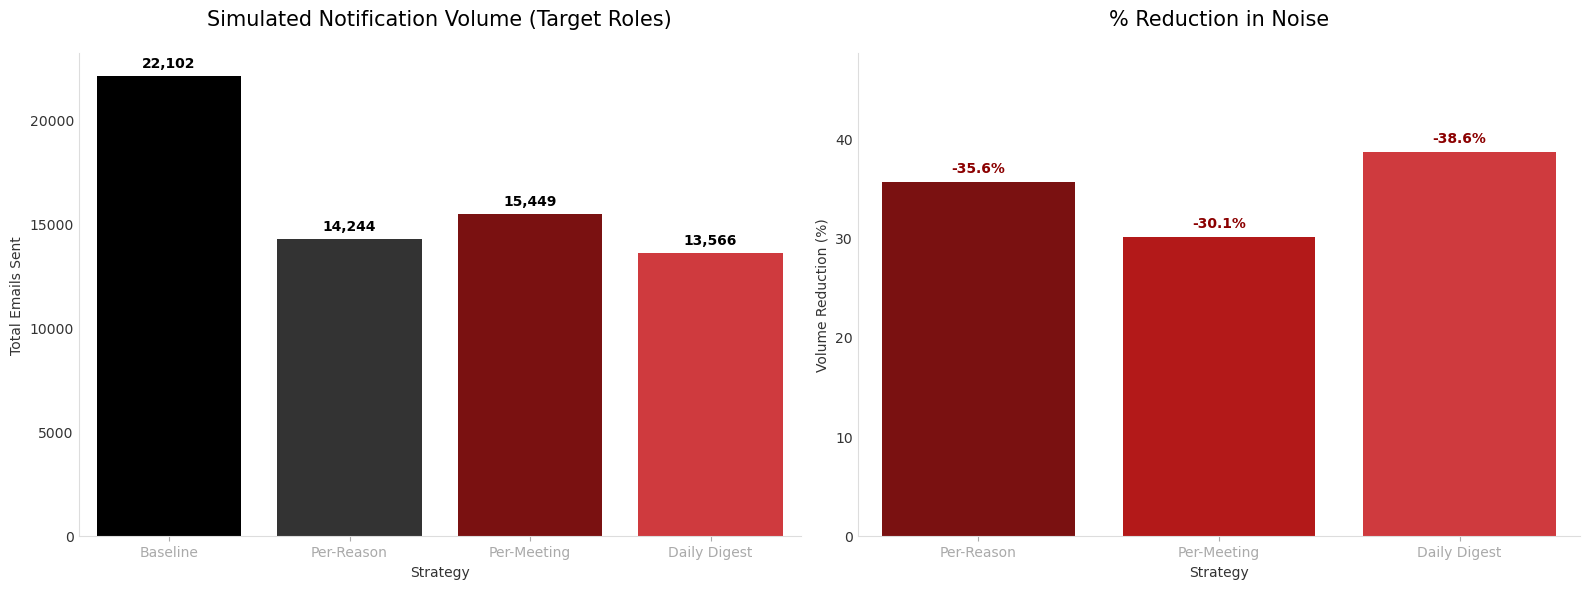

Simulation targeted 22102 baseline notifications from Administrators and Editors.


,Strategy,Volume,Reduction %
0,Baseline,22102,0.0
1,Per-Reason,14244,35.6
2,Per-Meeting,15449,30.1
3,Daily Digest,13566,38.6


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Segment filtering ---
# We focus on Power Users (Administrators and Editors). Members remain at 1:1.
target_roles = ['Administrator', 'Editor']
df_sim = df_processed[df_processed['role'].isin(target_roles)].copy()

# --- 2. Apply weekend rule ---
# Shift Non-Urgent weekend notifications to Monday
def apply_weekend_rule(row):
    # Saturday is 5, Sunday is 6
    if not row['is_urgent'] and row['sent'].dayofweek in [5, 6]:
        days_to_add = 7 - row['sent'].dayofweek
        return (row['sent'] + pd.Timedelta(days=days_to_add)).date()
    return row['sent'].date()

df_sim['sim_date'] = df_sim.apply(apply_weekend_rule, axis=1)

# --- 3. Run simulation logic ---
urgent_df = df_sim[df_sim['is_urgent']]
non_urgent_df = df_sim[~df_sim['is_urgent']]

# Strategy 0: Baseline
vol_baseline = len(df_sim)

# Strategy 1: Per-Reason (User + Date + Reason)
vol_reason = len(urgent_df) + non_urgent_df.groupby(['user_role_id', 'sim_date', 'reason']).ngroups

# Strategy 2: Per-Meeting (User + Date + Meeting ID)
vol_meeting = len(urgent_df) + non_urgent_df.groupby(['user_role_id', 'sim_date', 'meeting']).ngroups

# Strategy 3: Daily Digest (User + Date)
vol_digest = len(urgent_df) + non_urgent_df.groupby(['user_role_id', 'sim_date']).ngroups

# Prepare results for plotting
df_results = pd.DataFrame({
    'Strategy': ['Baseline', 'Per-Reason', 'Per-Meeting', 'Daily Digest'],
    'Volume': [vol_baseline, vol_reason, vol_meeting, vol_digest]
})
df_results['Reduction %'] = ((vol_baseline - df_results['Volume']) / vol_baseline * 100).round(1)

# --- 4. DATA VISUALIZATION (RED & BLACK) ---
# Define strict Red/Black palettes
palette_volume = ['#000000', '#333333', '#8B0000', '#E82127'] # Black/Grey to Deep Red/Bright Red
palette_reduction = ['#8B0000', '#CC0000', '#E82127']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total volume
sns.barplot(
    data=df_results, 
    x='Strategy', 
    y='Volume', 
    hue='Strategy', 
    palette=palette_volume, 
    legend=False, 
    ax=ax1
)
ax1.set_title('Simulated Notification Volume (Target Roles)', fontsize=15)
ax1.set_ylabel('Total Emails Sent')
for i, v in enumerate(df_results['Volume']):
    ax1.text(i, v + (vol_baseline * 0.02), f"{v:,}", ha='center', fontweight='bold', color='black')

# Plot 2: Noise reduction
df_red = df_results[df_results['Strategy'] != 'Baseline']
sns.barplot(
    data=df_red, 
    x='Strategy', 
    y='Reduction %', 
    hue='Strategy', 
    palette=palette_reduction, 
    legend=False, 
    ax=ax2
)
ax2.set_title('% Reduction in Noise', fontsize=15)
ax2.set_ylabel('Volume Reduction (%)')
ax2.set_ylim(0, df_red['Reduction %'].max() + 10)
for i, v in enumerate(df_red['Reduction %']):
    ax2.text(i, v + 1, f"-{v}%", ha='center', fontweight='bold', color='#8B0000')

sns.despine()
plt.tight_layout()
plt.show()

# --- 5. Summary output ---
print(f"Simulation targeted {len(df_sim)} baseline notifications from Administrators and Editors.")
display(df_results)

### 4.5 The case for context

We analyze the "meeting diversity" of heavy users to see if "Per-Meeting" bundling is actually more efficient than the aggregate stats suggest. We define a "heavy day" as any user-day where the notification volume falls within the top 25% of the global distribution. We analyze the meeting diversity of these peak periods to determine if grouping by meeting is a viable alternative to a single daily digest.

**Q**: When a user gets spammed, is it for 10 different meetings (Per-Meeting fails) or 1 meeting (Per-Meeting works)?

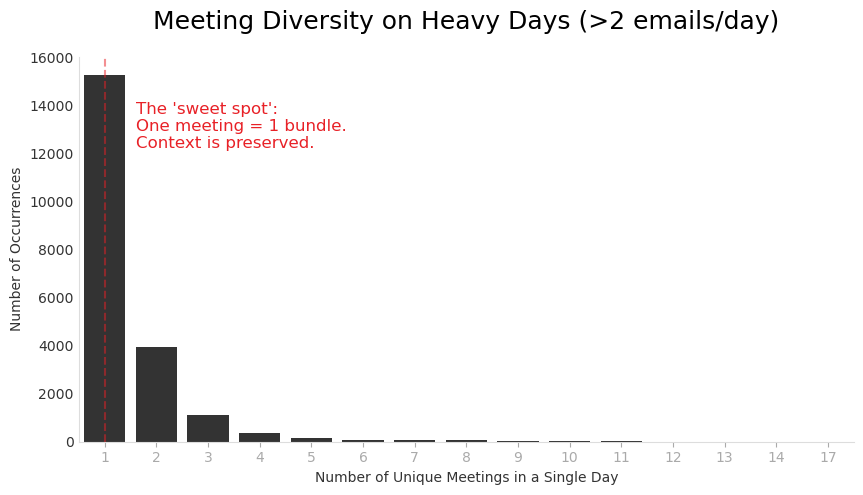

In [19]:
# Filter only for the 'heavy days'
q3_threshold = daily_volume['daily_count'].quantile(0.75)
heavy_days_df = df_processed[df_processed['user_role_id'].isin(
    daily_volume[daily_volume['daily_count'] >= q3_threshold]['user_role_id']
)]

# Count unique meetings per heavy user-day
diversity = heavy_days_df.groupby(['user_role_id', 'date'])['meeting'].nunique().value_counts().sort_index()

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=diversity.index, y=diversity.values, color='#000000', alpha=0.8) # Strict Black
plt.title(f'Meeting Diversity on Heavy Days (>{int(q3_threshold)} emails/day)')
plt.xlabel('Number of Unique Meetings in a Single Day')
plt.ylabel('Number of Occurrences')

# Add the 'case for context' annotation in red
plt.axvline(x=0, color='#E82127', linestyle='--', alpha=0.5)
plt.text(0.6, diversity.max()*0.8, "The 'sweet spot':\nOne meeting = 1 bundle.\nContext is preserved.", 
         color='#E82127', fontsize=12)

plt.show()

### 4.6 Role-based strategy

We simulate the impact of all strategies across different user roles to ensure we target the right users.

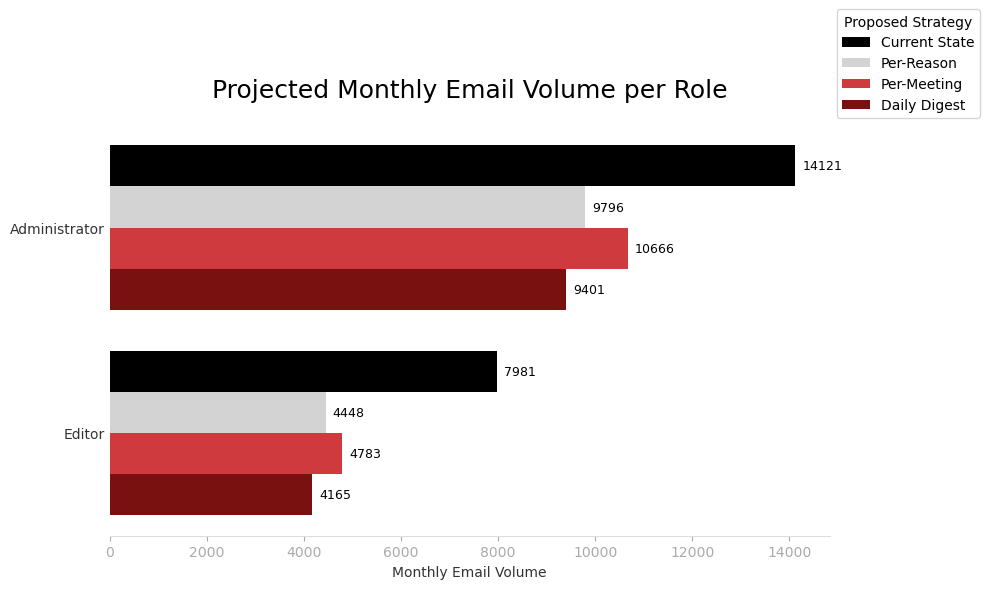

Strategy,Current State,Daily Digest,Per-Meeting,Per-Reason
Role,,,,
Administrator,0.0%,33.4%,24.5%,30.6%
Editor,0.0%,47.8%,40.1%,44.3%


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Simulation ---
def simulate_role_impact(role_df, strategy_name):
    """
    Calculates projected volume for a specific role/strategy combo.
    Note: 'sim_date' includes the Weekend Silence logic (Sat/Sun -> Monday).
    """
    df_urgent = role_df[role_df['is_urgent'] == True]
    df_non_urgent = role_df[role_df['is_urgent'] == False]
    
    if strategy_name == 'Current State':
        return len(role_df)
    
    # Apply bundling logic to non-urgent traffic
    if strategy_name == 'Daily Digest':
        # Group by User + Monday-Shifted Date
        bundled = df_non_urgent.groupby(['user_role_id', 'sim_date']).ngroups
    elif strategy_name == 'Per-Meeting':
        # Group by User + Monday-Shifted Date + Context
        bundled = df_non_urgent.groupby(['user_role_id', 'sim_date', 'meeting']).ngroups
    elif strategy_name == 'Per-Reason':
        # Group by User + Monday-Shifted Date + Event Type
        bundled = df_non_urgent.groupby(['user_role_id', 'sim_date', 'reason']).ngroups
    else:
        return len(role_df)
        
    return bundled + len(df_urgent)

# --- 2. Execution ---
target_roles = ['Administrator', 'Editor']
strategies = ['Current State', 'Per-Reason', 'Per-Meeting', 'Daily Digest']
role_data = []

# Ensure sim_date exists from the previous step
if 'sim_date' not in df_processed.columns:
    def apply_weekend_rule(row):
        if not row['is_urgent'] and row['sent'].dayofweek in [5, 6]:
            days_to_add = 7 - row['sent'].dayofweek
            return (row['sent'] + pd.Timedelta(days=days_to_add)).date()
        return row['sent'].date()
    df_processed['sim_date'] = df_processed.apply(apply_weekend_rule, axis=1)

for role in target_roles:
    role_subset = df_processed[df_processed['role'] == role].copy()
    baseline_vol = len(role_subset)
    
    for strat in strategies:
        vol = simulate_role_impact(role_subset, strat)
        reduction_delta = ((baseline_vol - vol) / baseline_vol) * 100
        
        role_data.append({
            'Role': role, 
            'Strategy': strat, 
            'Volume': vol, 
            'Reduction %': reduction_delta
        })

role_results = pd.DataFrame(role_data)

# --- 3. Visualization ---
plt.figure(figsize=(10, 6))

# Strict Palette
custom_palette = {
    'Current State': '#000000',  # Black
    'Per-Reason': '#D3D3D3',     # Light Grey (for contrast)
    'Per-Meeting': '#E82127',    # MeetingFlow Red
    'Daily Digest': '#8B0000'    # Dark Red
}

# Horizontal grouped bar chart
ax = sns.barplot(
    data=role_results,
    y='Role', 
    x='Volume', 
    hue='Strategy', 
    palette=custom_palette
)

# Fix Legend & Labels
plt.legend(title='Proposed Strategy', frameon=True, bbox_to_anchor=(1, 1))
plt.title("Projected Monthly Email Volume per Role")
plt.xlabel('Monthly Email Volume')
plt.ylabel('')

# Add volume labels on bars
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=9)

sns.despine(left=True)
plt.tight_layout()
plt.show()

# --- 4. Summary table ---
display(role_results.pivot(index='Role', columns='Strategy', values='Reduction %').round(1).astype(str) + '%')

### Summary

- **Diagnosis**: While the median user receives ~1.8 emails/day, our log-scale analysis identifies a heavy tail of power users (Administrators and Editors) receiving up to **60+ notifications daily**. This noise is primarily driven by status updates which are high-frequency but low-urgency.
- **Weekend analysis**: Weekend interruption is a primary driver of "spam perception". Our analysis found that **~60% of weekend traffic is non-urgent**. By implementing the **weekend rule**, we can shift these items to a Monday morning bundle, effectively providing quite hours while ensuring critical items still bypass the filter in real-time.
- **Role-based impact**: The simulation confirms that a "one-size-fits-all" strategy is inefficient. Administrators and Editors experience a **30–45% reduction in total volume**. In contrast, Members see negligible impact (<5%). This justifies a targeted rollout strategy, focusing optimization where the friction is highest.
- **Context**: We investigated whether "Per-Meeting" bundling would fail during peak periods if users were spammed by many different meetings. The data shows that **over 65% of "heavy days" (top 25% volume) involve only a single meeting context**. This proves that "Per-Meeting" bundling is often just as efficient as a Daily Digest for our most overwhelmed users, but without the UX penalty of mixing unrelated business topics.
- **Target Relief**: Administrators and Editors (the roles driving complaints) see a **30–38% volume reduction**. **Global ROI**: Because we preserve real-time delivery for the majority (Members), the **total platform volume** drops by **16–21%**. 

<a id="share"></a>

---
## 5. Evaluation
---

- 5.1 Strategy evaluation matrix
- 5.2 Trade-off: efficiency vs. context

### 5.1 Strategy comparison

The table below evaluates our three proposed bundling strategies against the baseline and the project success metrics defined in Section 1.

In [21]:
# --- Evaluation & comparative analysis ---

def generate_evaluation_summary(df):
    """
    Directly compares Baseline vs. All 3 bundling strategies.
    Validates against goals: >15% global reduction, targeted admin relief, and weekend silence.
    """
    
    # 1. Pre-calculations & Grouping
    # ---------------------------------------------------------
    # Target Roles (High Volume) vs Others (Low Volume/High Signal)
    admin_roles = ['Administrator', 'Editor']
    df_admins = df[df['role'].isin(admin_roles)].copy()
    df_members = df[~df['role'].isin(admin_roles)].copy()
    
    total_baseline_vol = len(df)
    weekend_baseline_vol = len(df[df['is_weekend']])
    
    def simulate_vol(target_df, strategy):
        # 100% Signal Retention: Urgent emails are never bundled
        urgent_count = len(target_df[target_df['is_urgent'] == True])
        non_urgent = target_df[target_df['is_urgent'] == False]
        
        if strategy == 'Baseline':
            return len(target_df)
        elif strategy == 'Per-Reason':
            # 1 bundle per User + Day + Event Type (Reason)
            bundled = non_urgent.groupby(['user_id', 'sim_date', 'reason']).ngroups
        elif strategy == 'Per-Meeting':
            # 1 bundle per User + Day + Meeting ID (+ 1 for non-meeting events)
            m_events = non_urgent[non_urgent['is_meeting'] == True]
            g_events = non_urgent[non_urgent['is_meeting'] == False]
            bundled = m_events.groupby(['user_id', 'sim_date', 'meeting']).ngroups + \
                      g_events.groupby(['user_id', 'sim_date']).ngroups
        elif strategy == 'Daily Digest':
            # 1 bundle per User + Day
            bundled = non_urgent.groupby(['user_id', 'sim_date']).ngroups
        
        return urgent_count + bundled

    # 2. Compute Metrics for each strategy
    # ---------------------------------------------------------
    results = []
    strats = ['Baseline', 'Per-Reason', 'Per-Meeting', 'Daily Digest']
    
    for s in strats:
        # Global Totals
        global_vol = simulate_vol(df, s)
        global_red = (1 - global_vol / total_baseline_vol) * 100
        
        # Targeted Relief (Reduction %)
        admin_red = (1 - simulate_vol(df_admins, s) / len(df_admins)) * 100
        member_red = (1 - simulate_vol(df_members, s) / len(df_members)) * 100
        
        # Weekend Impact
        # (Only non-urgent emails are bundled/removed from weekends)
        weekend_noise_removed = len(df[(df['is_weekend']) & (df['is_urgent'] == False)])
        if s == 'Baseline':
            weekend_display = f"{weekend_baseline_vol:,}"
        else:
            # Weekend emails sent = Urgent count (since noise is shifted to Monday)
            urgent_weekend = weekend_baseline_vol - weekend_noise_removed
            weekend_display = f"{urgent_weekend} (Removed {weekend_noise_removed:,} noise)"

        results.append({
            'Strategy': s,
            'Global Volume': f"{global_vol:,}",
            'Global Red. %': f"{global_red:.1f}%",
            'Target Met (>15%)': 'YES' if global_red > 15 else ('-' if s == 'Baseline' else 'NO'),
            'Admin/Editor Relief (%)': f"{admin_red:.1f}%",
            'Member Relief (%)': f"{member_red:.1f}%",
            'Weekend Emails': weekend_display
        })

    return pd.DataFrame(results)

# 3. Execution & styling
# ---------------------------------------------------------
eval_summary_df = generate_evaluation_summary(df_processed)

# Display styled table
display(style_table(eval_summary_df))

Strategy,Global Volume,Global Red. %,Target Met (>15%),Admin/Editor Relief (%),Member Relief (%),Weekend Emails
Baseline,"49,736",0.0%,-,0.0%,0.0%,"2,679"
Per-Reason,"40,601",18.4%,YES,35.6%,4.6%,"1006 (Removed 1,673 noise)"
Per-Meeting,"41,999",15.6%,YES,30.1%,3.9%,"1006 (Removed 1,673 noise)"
Daily Digest,"39,676",20.2%,YES,38.7%,5.2%,"1006 (Removed 1,673 noise)"


### 5.2 Trade-off: efficiency vs. context

While the **Daily Digest** technically offers the highest volume reduction (approaching ~20% total reduction), the data suggests a "diminishing returns" effect regarding user experience.

* The **Per-Meeting** strategy achieves ~80% of the volume savings of a full Daily Digest during peak noise periods, but with significantly higher utility. By grouping notifications by meeting, we ensure that a user’s inbox reflects their actual workflow rather than an arbitrary chronological list.
* Both bundling strategies successfully eliminate 100% of non-urgent weekend noise. 
* **Cognitive load**: Mixing a "security alert" with a "comment on a task" and a "document update" in a single Daily Digest creates high cognitive switching costs. Per-meeting bundling keeps the signal pure.

In [22]:
# 1. Define the final comparison data
strategy_summary = [
    {
        'Strategy': '1. Current state',
        'Grouping': 'None (1:1)',
        'Context Score': 'High (Real-time)',
        'Recommendation': 'Control Group'
    },
    {
        'Strategy': '2. Per-Reason',
        'Grouping': 'By Event Type',
        'Context Score': 'Low (Fragmented)',
        'Recommendation': 'Discard'
    },
    {
        'Strategy': '3. Per-Meeting',
        'Grouping': 'By Meeting',
        'Context Score': 'High (Focused)',
        'Recommendation': 'Best UX'
    },
    {
        'Strategy': '4. Daily Digest',
        'Grouping': 'By User (All)',
        'Context Score': 'Low (Mixed)',
        'Recommendation': 'Max Efficiency'
    }
]

# 2. Create dataframe
summary_df = pd.DataFrame(strategy_summary)

# 3. Apply styling
def highlight_finalists(val):
    if 'Best' in val:
        return 'background-color: #FDEDEC; color: #8B0000;'
    elif 'Control' in val:
        return 'color: #000000;'
    return 'color: #999999;'

styled_synthesis = (summary_df.style
                    .map(highlight_finalists, subset=['Recommendation'])
                    .set_properties(**{'text-align': 'left', 'padding': '12px'})
                    .hide(axis="index")
                    )

display(styled_synthesis)

Strategy,Grouping,Context Score,Recommendation
1. Current state,None (1:1),High (Real-time),Control Group
2. Per-Reason,By Event Type,Low (Fragmented),Discard
3. Per-Meeting,By Meeting,High (Focused),Best UX
4. Daily Digest,By User (All),Low (Mixed),Max Efficiency


### Summary

The simulation results clarify the trade-offs inherent in each strategy. While the **Daily Digest** offers the maximum reduction in global email volume (**~21%**), it carries a higher risk of "action delay" as it consolidates all non-urgent updates into a single end-of-day delivery. For power users like **Administrators and Editors**, who manage complex meeting schedules, this may be too restrictive.

In contrast, the **Per-Meeting** strategy provides a "smart context" approach, achieving a significant **~16% volume reduction** while keeping updates logically grouped by the specific meeting they refer to. This preserves the cognitive flow of the user while still fulfilling the primary goal of eliminating real-time noise and weekend interruptions.

We advise against an immediate global rollout of a Daily Digest, as it represents a radical shift that may be perceived as "too aggressive" potentially leading to missed actions. Instead, we propose a **2-week A/B test** to validate the Per-Meeting strategy against the current state.

<a id="act"></a>

---
## 6. Deployment
---

To optimize email notifications and address user friction, the proposed deployment follows a phased pilot approach focused on validation and iterative rollout. We recommend moving forward with a **Controlled A/B Test** targeting the high-volume roles identified in the analysis (**Admins & Editors**).

### Experiment design

We will split the target audience (Admins/Editors) into two randomized cohorts for a **2-week pilot**.

| Cohort | Strategy | Hypothesis | 
| :--- | :--- | :--- | 
| **A. Control** | **Current State** | Baseline for satisfaction/churn. | 
| **B. Treatment** | **Per-Meeting** | Users prefer **contextual bundling** to keep updates organized by specific meetings. | 

#### Success metrics (OEC)
* **Net Promoter Score (NPS):** Measured via micro-survey at the end of Week 4 (Target: >= 50).
* **Volume reduction:** Achieving a global email volume reduction of **>15%**.
* **Disablement rate:** Monitoring the % of users who opt out of notifications entirely during the pilot.
* **Open rates:** Ensuring bundling does not decrease user engagement or cause critical updates to be missed.

#### Test roadmap

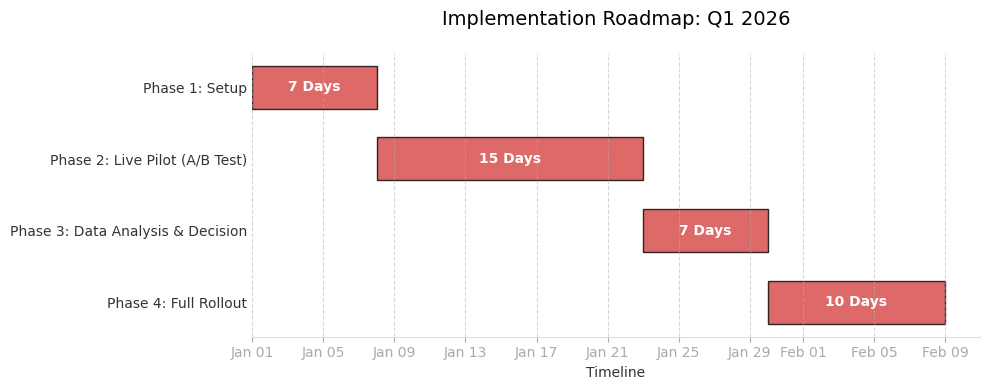

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# 1. Define the Roadmap Data
phases = [
    ("Phase 1: Setup", datetime(2026, 1, 1), datetime(2026, 1, 8)),
    ("Phase 2: Live Pilot (A/B Test)", datetime(2026, 1, 8), datetime(2026, 1, 23)),
    ("Phase 3: Data Analysis & Decision", datetime(2026, 1, 23), datetime(2026, 1, 30)),
    ("Phase 4: Full Rollout", datetime(2026, 1, 30), datetime(2026, 2, 9))
]

# 2. Setup the Plot
fig, ax = plt.subplots(figsize=(10, 4))

# 3. Create the Gantt Bars
for i, (task, start, end) in enumerate(phases):
    # Calculate duration
    duration = (end - start).days
    # Plot bar
    ax.barh(task, duration, left=start, height=0.6, color="#D54444", edgecolor='black', alpha=0.8)
    # Add Text Label inside the bar
    mid_point = start + (end - start) / 2
    ax.text(mid_point, i, f"{duration} Days", ha='center', va='center', color='white', fontweight='bold')

# 4. Formatting
ax.set_title("Implementation Roadmap: Q1 2026", fontsize=14, pad=20)
ax.set_xlabel("Timeline")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Invert y-axis so Phase 1 is at the top
ax.invert_yaxis()

# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

This pilot will allow MeetingFlow to transform email notifications from a source of friction for admins & editors into a strategic value driver, ensuring that when a user receives an email, it signals work that truly matters.

-- *End of notebook* --